# Income Classification

## Introduction

In this income classification project, our objective is to identify the key characteristics associated with individuals who earn more or less than $50,000 per year. We will be working with a sample dataset from the US Census archive, which provides a comprehensive set of demographic, socioeconomic, and employment-related attributes for a diverse group of ~300,000 individuals. The dataset contains valuable information that can help us gain insights into the factors that contribute to income levels.

The focus of our research question revolves around understanding the relationship between various features in the dataset and the target variable, which represents whether an individual earns more or less than $50,000 annually. By examining these characteristics, we aim to build a predictive model that can accurately classify individuals into their respective income categories based on their attributes.

Identifying the factors that contribute to higher or lower incomes is crucial for several reasons. It can provide valuable insights into income inequality, socioeconomic disparities, and the factors that influence financial success. Understanding these factors can help policymakers, organizations, and individuals make informed decisions and design targeted interventions to promote upward mobility and improve economic well-being.

Throughout this project, we will leverage various machine learning techniques and statistical analysis methods to explore the dataset, preprocess the data, perform feature engineering, and train predictive models. Our goal is to uncover the most influential features and develop a robust classification model that can effectively distinguish between high and low-income individuals.

By successfully identifying the characteristics associated with different income levels, we can contribute to the understanding of socioeconomic dynamics and provide practical insights for decision-making in areas such as policy formulation, resource allocation, and economic planning.

Let's dive into the analysis and explore the census dataset to uncover the key factors that influence income classification.








## Setup

We start by importing the python packages needed for the project.

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
import os
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE


Next, we import source functions from the src folder. To enable this, we set the working directory to the home folder.

In [8]:
# Navigate to root
if os.getcwd().endswith("analysis"):
    PATH_TO_ROOT = "../"
    os.chdir(PATH_TO_ROOT)
os.getcwd() 

'C:\\Users\\joeje\\Documents\\income_classification'

In [9]:
# import source functions
from src.preprocessing import * 
from src.feature_engineering import *

#### Load Raw Data

Now, we load the raw data from the `data` folder. Our data was already split into train and test sets.

In [10]:
train = load_data("data/census_income_learn.csv")
test = load_data("data/census_income_test.csv")

We examine the dataset using the head() method.

In [11]:
train.head()

,age,workclass,industry_code,occupation_code,education,wage_ph,educ_last_wk,marital_status,maj_ind_code,maj_occ_code,...,father_country,mother_country,self_country,citizenship,own_business,vet_quest,vet_benefit,weeks_worked,year,income
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


The unit of observation in the dataset is an individual. The last column is the target variable. It classifies individuals' annual income above or below $50,000. 

We check the dimensions of the datasets. Both train and test sets have 42 columns. The train set has over twice as many observations as the test set.

In [12]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (199523, 42)
Test shape: (99762, 42)


We also check for missing values using the `get_missing_columns` function. We find that there are no native missing values in the dataset.

In [13]:
get_missing_columns(train)

Series([], dtype: float64)

## Pre-processing

In this section, we focus on data preprocessing to ensure the data is in the appropriate format for analysis. The preprocessing steps that are relevant to columns are applied consistent across both the train and test sets to maintain uniformity. This is important because when we train and evaluate our models, having consistent data formatting facilitates reliable model performance assessment and comparison. By preprocessing the data in a standardized manner, we can ensure that any differences in model outcomes are primarily driven by the models themselves rather than inconsistencies in the data.

#### Dimensionality Reduction

Dimensionality reduction is a valuable technique used in many data analysis and machine learning projects. For this project, we are applying dimensionality reduction to address the challenges posed by high-dimensional data. High-dimensional data refers to datasets with a large number of features or variables (typically more than 10). Although having abundant information can be beneficial, it can also lead to issues such as increased computational complexity, the curse of dimensionality, and overfitting. By reducing the dimensionality of the data, we aim to overcome these challenges.

To start, we drop some columns based on our domain expertise and considerations. The following columns are excluded from our analysis:

- `instance_weight`: We do not take into account the weight of each observation in the general population, as it is not relevant to our research question.
- `industry_code` and `occupation_code`: The information contained in these columns is already captured in the major industry code and major occupation code variables, respectively, making them redundant.
- `educ_last_wk`: This variable, which indicates an individual's education level from the previous week, is sparse as it does not apply to many respondents. Therefore, we exclude it from our analysis.
- `region_prev_res` and `state_prev_res`: These variables, which provide information about an individual's previous residential state and region, respectively, are also sparse and do not apply to a significant number of respondents who are non-movers. Hence, we remove them from our dataset.
- `household_details`: This column offers a more detailed version of the household_summary variable. To reduce dimensionality and avoid redundancy, we drop household_details.
- `citizenship`: Since there is already another column (`sself_country`) that provides information about an individual's nationality, we exclude the `citizenship` column and rely on `self_country` instead.
- `vet_quest`: This column is sparsely populated, and we can already determine if an individual is a veteran using the `vet_benefit` column. Hence, we remove `vet_quest` from our dataset.
- `employer_size`: This variable exhibits high correlation with the number of weeks worked. This may be because both variables indicate that an individual is working. Since the latter has higher variance, we decide to drop `employer_size` from our analysis.

By dropping these columns, we aim to streamline our dataset and focus on the most relevant variables for our income classification task.

In [14]:
# define columns to drop
cols_to_drop = ["instance_weight", "industry_code", "occupation_code", "educ_last_wk",
                "unemp_type", "region_prev_res", "state_prev_res", "household_details", "citizenship",
                "vet_quest", "employer_size"]

# drop columns from both train and test sets
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [15]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (199523, 31)
Test shape: (99762, 31)


#### Fix data types

Next, we proceed to verify and adjust the data types of each variable to align with their intended meaning and the requirements of our models. Our initial step involves examining the current data types assigned to each variable.

In [16]:
train.dtypes

age                      int64
workclass               object
education               object
wage_ph                  int64
marital_status          object
maj_ind_code            object
maj_occ_code            object
race                    object
hispanic_origin         object
sex                     object
union_member            object
emp_status              object
capgain                  int64
caploss                  int64
stock_div                int64
tax_filer_status        object
household_summary       object
migration_msa           object
migration_reg           object
migration_within_reg    object
live_here_year_ago      object
migration_sunbelt       object
presence_of_parents     object
father_country          object
mother_country          object
self_country            object
own_business             int64
vet_benefit              int64
weeks_worked             int64
year                     int64
income                  object
dtype: object

We notice that some categorical variables like `own_business`, `vet_benefit`, and `year` are wrongly coded as integers, so we start by changing those to type:category. Next, we convert all object types to category. This step ensures that our data types are consistent and ready for modeling later.

In [17]:
# columns to convert to category
cols_to_category = ["own_business", "vet_benefit", "year"]
train[cols_to_category] = train[cols_to_category].astype("category")
test[cols_to_category] = test[cols_to_category].astype("category")

# convert object datatypes to category
train[train.select_dtypes(include="object").columns] = train.select_dtypes(include="object").astype("category")
test[test.select_dtypes(include="object").columns] = test.select_dtypes(include="object").astype("category")

We check the data types again to verify that they are as intended.

In [18]:
train.dtypes

age                        int64
workclass               category
education               category
wage_ph                    int64
marital_status          category
maj_ind_code            category
maj_occ_code            category
race                    category
hispanic_origin         category
sex                     category
union_member            category
emp_status              category
capgain                    int64
caploss                    int64
stock_div                  int64
tax_filer_status        category
household_summary       category
migration_msa           category
migration_reg           category
migration_within_reg    category
live_here_year_ago      category
migration_sunbelt       category
presence_of_parents     category
father_country          category
mother_country          category
self_country            category
own_business            category
vet_benefit             category
weeks_worked               int64
year                    category
income    

### Feature Engineering

Feature engineering plays a crucial role in our project by transforming and creating new features from the existing dataset. These engineered features aim to capture important patterns and relationships that can improve the accuracy and interpretability of our models for income classification.

#### Investment Income

To capture the overall impact of investments, we perform feature engineering by combining the variables `capgain`, `caploss`, and `stock_div`. By creating a new variable `investment_income = capgain - caploss + stock_div`, we consolidate the information related to investments into a single feature. This simplifies the dataset and removes the need to consider the individual variables separately. Consequently, we can enhance the predictive power of our models by incorporating this aggregated feature while discarding the original columns.

In [19]:
# create investment_income in train and test sets
train['investment_income'] = train['capgain'] - train['caploss'] + train['stock_div']
test['investment_income'] = test['capgain'] - test['caploss'] + test['stock_div']

# drop original columns
cols_to_drop = ['capgain', 'caploss', 'stock_div']
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

#### Mapping Categorical Variables

In order to simplify the analysis of categorical variables, we perform a mapping step to reduce the number of distinct categories. By grouping certain categories together, we aim to create more meaningful and concise representations of the data. This mapping process allows us to transform the original categorical variables into a reduced set of categories, providing a clearer understanding of their impact on the target variable. Through this mapping, we can effectively capture the essential information from the categorical variables while maintaining interpretability in our analysis.

In [20]:
# The 'train' and 'test' datasets are updated using the pipe method to apply the mapping functions sequentially.

train = (
    train.pipe(map_workclass)
    .pipe(map_education)
    .pipe(map_hispanic)
    .pipe(map_tax_filer_status)
    .pipe(map_household_summary)
    .pipe(map_father_country)
    .pipe(map_mother_country)
    .pipe(map_self_country)
    .pipe(map_emp_status)
)

test = (
    test.pipe(map_workclass)
    .pipe(map_education)
    .pipe(map_hispanic)
    .pipe(map_tax_filer_status)
    .pipe(map_household_summary)
    .pipe(map_father_country)
    .pipe(map_mother_country)
    .pipe(map_self_country)
    .pipe(map_emp_status)
)

In [21]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (199523, 29)
Test shape: (99762, 29)


Below, we check again for missing values and notice that one of the mapping steps introduced missing values to the `hispanic_origin` variable. These were coded as `NA` or `Do not know`. We will handle these later.

In [22]:
get_missing_columns(train)

hispanic_origin    1180
dtype: int64

### EDA: Counts of target classes

We check for class balance in the target variable `income`.

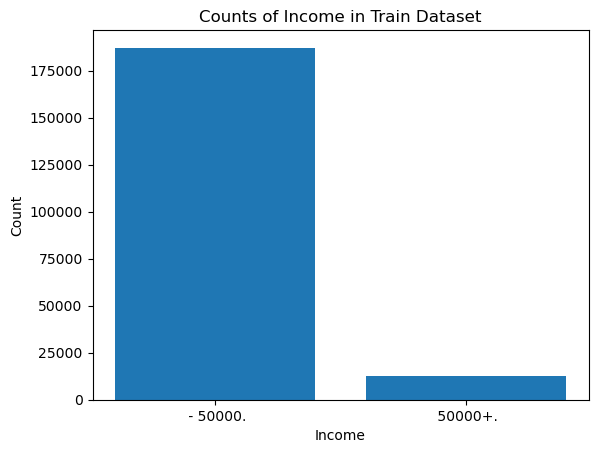

In [23]:
# create counts of target classes
income_counts = train['income'].value_counts()

# plot target class counts
plt.bar(income_counts.index, income_counts.values)
plt.xlabel('Income')
plt.ylabel('Count')
plt.title('Counts of Income in Train Dataset')
plt.show()

### Filtering Rows in Train Set

The plot above shows that the target class is highly imbalanced. We can take some preliminary steps to address this concern now in the train set.

#### Dropping Duplicates

We address the issue of duplicate records in our dataset. Duplicate records can introduce bias and affect the integrity of our analysis. Therefore, it is important to identify and remove these duplicates before proceeding with further data processing. This ensures that our analysis is based on unique and representative observations. Most of the duplicate records belong to the majority target class, so this step helps address imbalance.

#### Dropping Children (age<15)

During the exploratory data analysis (separate R file in directory), we learned that children (persons under 15 years of age) do not work. Thus, they cannot earn an income. We drop them all because they contribute to the target imbalance.

In [24]:
train = (
    train.pipe(drop_children)
    .pipe(drop_duplicates)
)

In [25]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (129017, 29)
Test shape: (99762, 29)


## Final Data Preparation

To get our data ready for modeling, we one-hot encode categorical variables and do a train-test split.

#### Train-test split

In order to evaluate the performance of our machine learning model and ensure its generalization, we need to split our dataset into two distinct subsets: train, and test.

The train set will be used to train the model and the test set will be used for final evaluation of the model's performance on unseen data.

By splitting the data, we can assess the model's ability to generalize to new, unseen examples and avoid overfitting. This process helps us make more reliable predictions on future data.

The train and test splits were already made before the project.

**Note**: We originally created a validation set to help with hyperparamter tuning. However, we were unable to complete this process due to low computing power, so chose to disable the validation set and regain more data in the train set.

In [26]:
# create feature and target sets for test and train sets
X_test = test.drop(['income'],axis=1)
y_test = test['income']
X_train = train.drop(['income'],axis=1)
y_train = train['income']

# split the train sets into train and validation sets
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
# print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (129017, 28)
Test shape: (99762, 28)


#### Create dummies

When working with categorical variables in our dataset, we often need to convert them into numerical form to incorporate them into our machine learning models. One common approach is to create dummy variables. Dummy variables, also known as indicator variables, are binary variables that represent the presence or absence of a specific category within a categorical variable. Each category is encoded as a separate binary variable, where 1 indicates the presence of the category and 0 indicates the absence.

However, when creating dummy variables, we need to be mindful of the issue of multicollinearity. Multicollinearity occurs when there is a high correlation between two or more dummy variables, which can lead to unstable and unreliable model estimates. To address multicollinearity, we typically drop one of the dummy variables for each categorical variable, known as the reference category. The reference category serves as the baseline against which the other categories are compared. By excluding the reference category, we ensure linear independence among the dummy variables and avoid perfect multicollinearity.

By creating dummy variables and dropping the reference category, we can effectively incorporate categorical information into our models without introducing multicollinearity. This allows us to capture the impact of each category on the target variable while maintaining model stability and interpretability.

In [27]:
# Combine train and test sets
X_combined = pd.concat([X_train, X_test])

# Perform dummy encoding on the combined dataset
X_combined_dm = pd.get_dummies(X_combined, drop_first=True)

# Step 4: Split the combined dataset back into train, val and test sets
X_train = X_combined_dm[:len(X_train)]
#X_val = X_combined_dm[len(X_train):len(X_train)+len(X_val)]
X_test = X_combined_dm[len(X_train):]

# Check the shapes of train and test sets
print("Train shape:", X_train.shape)
#print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (129017, 118)
Test shape: (99762, 118)


In [28]:
X_train.head()

,age,wage_ph,weeks_worked,investment_income,workclass_Never worked,workclass_Other,workclass_Private,workclass_Self-employed,education_HSD and some college,education_No high school diploma,...,father_country_United States,mother_country_Other,mother_country_United States,self_country_Other,self_country_United States,own_business_1,own_business_2,vet_benefit_1,vet_benefit_2,year_95
0,73,0,0,0,0,1,0,0,1,0,...,1,0,1,0,1,0,0,0,1,1
1,58,0,52,0,0,0,0,1,1,0,...,1,0,1,0,1,0,0,0,1,0
2,18,0,0,0,0,1,0,0,0,1,...,0,1,0,1,0,0,0,0,1,1
5,48,1200,52,0,0,0,1,0,1,0,...,0,0,1,0,1,0,1,0,1,1
6,42,0,52,5178,0,0,1,0,0,0,...,1,0,1,0,1,0,0,0,1,0


#### Scaling numeric features

In this section, we focus on preparing our data by standardizing the range of numeric features. By applying techniques like normalization and standardization, we ensure that our features have similar scales and distributions. This step is crucial for many machine learning algorithms, as it helps prevent certain features from dominating others and ensures fair comparisons. Ultimately, feature scaling enhances the performance and stability of our models.

In [29]:
# define numeric columns
int_cols = train.select_dtypes("int64").columns

# initialize the scaler
scaler = preprocessing.StandardScaler()

In [30]:
# make a copy of each set
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
#X_val_copy = X_val.copy()

# fit the transform on the train set and apply to test
X_train_copy[int_cols] = scaler.fit_transform(X_train[int_cols]).copy()
#X_val_copy[int_cols] = scaler.transform(X_val[int_cols]).copy()
X_test_copy[int_cols] = scaler.transform(X_test[int_cols]).copy()

In [31]:
X_train = X_train_copy
#X_val = X_val_copy
X_test = X_test_copy

#### Addressing Class Imbalance in the Target Variable

In this section, we tackle the issue of class imbalance in our dataset. Class imbalance occurs when the number of instances in one class significantly outweighs the number of instances in the other class, leading to biased model performance. To mitigate this problem, we employ resampling techniques.

Resampling involves modifying the class distribution by either oversampling the minority class or undersampling the majority class. Oversampling increases the number of instances in the minority class, while undersampling decreases the number of instances in the majority class. These techniques aim to balance the class distribution, allowing the model to learn from a more representative sample.

We explore two common resampling methods: oversampling using the Synthetic Minority Over-sampling Technique (SMOTE) and undersampling using Near Miss Under Sampling.

By applying these resampling techniques, we can alleviate the impact of class imbalance and improve the performance of our models in accurately predicting the minority class. Finally, we settle on the undersampling approach for this project.

In [32]:
nm = NearMiss(sampling_strategy=0.2)
X_under, y_under = nm.fit_resample(X_train, y_train)
X_under, y_under = nm.fit_resample(X_train, y_train)

# Check the shapes of all three sets
print("Train shape:", X_under.shape)
#print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (73650, 118)
Test shape: (99762, 118)


## Modeling

In the modeling phase of our project, we apply various machine learning algorithms to train models that can accurately predict the income classification. We explore different algorithms such as Logistic Regression and Random Forests, to find the best-performing model for our task. We evaluate the models using appropriate performance metrics such as accuracy, precision, recall, and F1-score. Through this process, we aim to identify the most effective model that can generalize well to unseen data and provide reliable predictions for income classification.

We evaluate competing models by examining their performance on the validation set. If we had more time and computing power for this project, we would have Finally, we choose the best model and proceed to find important features that can help address our project question.

#### Hyperparameter tuning
Hyperparameter tuning plays a critical role in optimizing machine learning models. Hyperparameters are configuration settings that are set before training a model and can significantly impact its performance. By adjusting these hyperparameters, we aim to find the optimal combination that maximizes the model's performance metrics. Hyperparameter tuning involves systematically searching for the best hyperparameter values that strike the right balance between model complexity and generalizability. Through this process, we can enhance our models' accuracy, robustness, and ability to make accurate predictions on unseen data.

Unfortunately, we do not have enough computing power and time to conduct a thorough hyperparameter tuning process using a grid search for this dataset. Thus we use the default settings in some cases and conduct a manual tuning process to find "best" parameters for each of the models.

### Logistic Regression

We utilize logistic regression as a powerful algorithm for predicting whether an individual's income exceeds a certain threshold. Logistic regression is a popular choice for binary classification problems, where we aim to categorize instances into one of two classes.

Logistic regression works by estimating the probability of an instance belonging to a particular class based on its input features. Unlike linear regression, logistic regression uses a logistic function to transform the output into a probability value between 0 and 1. This makes it well-suited for tasks where we want to understand the likelihood of an outcome occurring.

By fitting the logistic regression model to our training data, we can learn the relationships between the input features and the target variable, allowing us to make predictions on new, unseen data. Logistic regression provides interpretable results, as we can examine the coefficients of the model to understand the direction and magnitude of the influence of each feature on the classification outcome.

In [35]:
# Create the Logistic Regression Classifier
lr = LogisticRegression(solver='liblinear', random_state=56)

# Train the classifier
lr.fit(X_under, y_under)

# Make predictions on the test set
y_pred = lr.predict(X_test)

In [36]:
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion matrix:
 [[90930  2646]
 [ 3692  2494]]

Classification Report:
               precision    recall  f1-score   support

    - 50000.       0.96      0.97      0.97     93576
     50000+.       0.49      0.40      0.44      6186

    accuracy                           0.94     99762
   macro avg       0.72      0.69      0.70     99762
weighted avg       0.93      0.94      0.93     99762



### Random Forest Classifier

We use the random forest algorithm as a robust approach for predicting whether an individual's income exceeds a certain threshold. Random forest is an ensemble learning method that combines multiple decision trees to make accurate and reliable predictions.

Random forest works by constructing an ensemble of decision trees, where each tree is built using a random subset of features and a random subset of the training data. The individual decision trees are trained to make predictions independently, and the final prediction is obtained by aggregating the predictions from all the trees.

The strength of random forest lies in its ability to handle complex relationships between features and the target variable. It can capture non-linear interactions, handle high-dimensional data, and handle missing values and outliers effectively. Additionally, random forest is resistant to overfitting and tends to provide robust performance even in the presence of noisy data.

By leveraging the power of random forest, we aim to identify the important features that contribute to income classification and develop a highly accurate predictive model. The random forest algorithm allows us to assess the importance of each feature, providing valuable insights into the factors that have the most significant impact on income classification.



In [65]:
# Create the random forest classifier
rf = RandomForestClassifier(n_estimators=45, max_depth=20, max_features='sqrt', random_state=23)

# Train the classifier
rf.fit(X_under, y_under)

# Make predictions on the test set
y_pred = rf.predict(X_test)

In [66]:
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion matrix:
 [[89745  3831]
 [ 3718  2468]]

Classification Report:
               precision    recall  f1-score   support

    - 50000.       0.96      0.96      0.96     93576
     50000+.       0.39      0.40      0.40      6186

    accuracy                           0.92     99762
   macro avg       0.68      0.68      0.68     99762
weighted avg       0.92      0.92      0.92     99762



#### Interpretation of Results and Model Selection

Both models achieve accuracy scores above 90%, with logistic regression attaining a score of 94% and random forest achieving 92%. However, given the nature of our problem, accuracy score is not sufficient to judge the models. We also check for the dropoff between precision and recall for the minority class.

When the precision and recall are similar for the minority class, it indicates a balanced performance in correctly identifying positive instances (minority class) while minimizing false positives. This scenario is particularly important in imbalanced classification problems where the minority class is of higher interest or significance.

For this reason, we select the random forest model for the next stage of our analysis.

## Feature Importance: Factors Affecting Income Class

Feature importance refers to the technique used to identify the most relevant features or variables that contribute significantly to the predictive power of a model. In the context of our project question of income classification, feature importance helps us understand which specific characteristics or factors are influential in determining whether a person makes more or less than $50,000 per year. By examining the feature importance, we can gain insights into the key drivers that differentiate the two income groups and understand which variables have the most significant impact on the classification outcome. This information can guide us in interpreting the model's predictions and potentially uncover important socio-economic or demographic factors associated with income levels.

#### Feature Importance of Our Random Forest Model

The feature importance in a Random Forest model is determined by assessing the contribution of each feature in the decision-making process of the ensemble. Random Forest calculates feature importance based on the concept of "Gini importance" or "mean decrease impurity." Gini importance measures the total reduction in impurity achieved by splitting on a particular feature across all trees in the forest. It quantifies how much a feature improves the homogeneity of the target variable within the nodes of the trees. Features that lead to the largest reduction in impurity are considered more important.

The feature importance values are normalized, with higher values indicating greater importance. The normalized importance values can be used to rank the features based on their relative significance in the model. By examining the feature importance in our Random Forest model, we can identify the key variables that contribute the most to the predictive performance of the model. These important features provide insights into which factors have the strongest influence on the target variable and can help in understanding the underlying patterns and relationships in the data.

##### Limitations
It is important to note that random forests have a stochastic nature, meaning the feature importances can vary across different runs of the model. To address this variability and obtain a more reliable assessment of feature importance, an ensemble of multiple random forests can be created. By training and evaluating a large number of random forests (e.g., 1000 models), the feature importances can be collected from each model and averaged out. This ensemble approach helps to reduce the impact of randomness and provides a more robust estimation of the true feature importances.

Unfortunately, due to limitations in computing power, we were unable to perform this ensemble of random forests in our project. However, it is worth considering in future studies or with access to more computational resources. This approach would provide a more comprehensive understanding of which features consistently contribute significantly to predicting income class, enhancing the reliability of our feature importance analysis.






In [67]:
# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({'Feature': X_under.columns, 'Importance': importances})

# Sort the DataFrame by feature importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


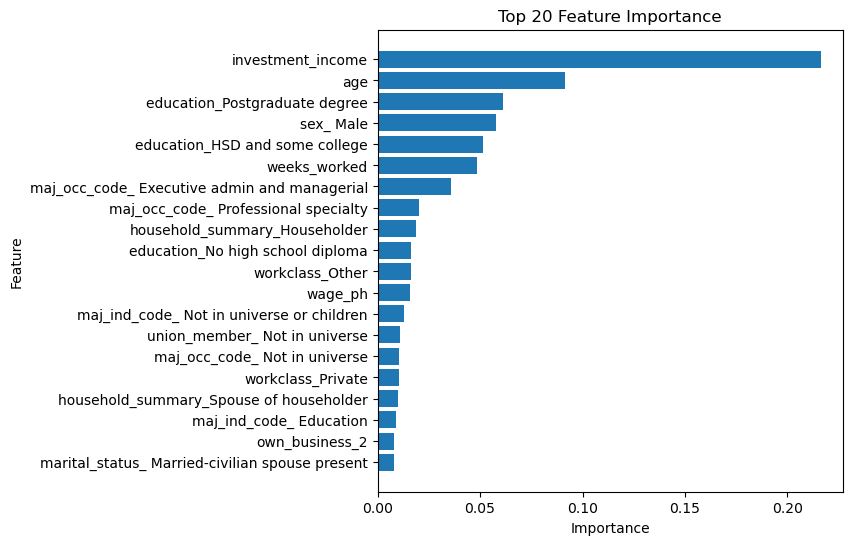

In [74]:
# Selecting the top twenty features
top_features = feature_importance_df.nlargest(20, 'Importance').sort_values('Importance', ascending=True)

# Plotting the top twenty feature importance
plt.figure(figsize=(6, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance')
plt.show()


## Conclusion

Based on the feature importance plot above, we see that invvestment income is an important feature in income classification because it provides insights into an individual's financial portfolio and wealth accumulation. Income from investments, such as capital gains, dividends, and stock sales, can significantly contribute to a person's overall income and financial stability.

In addition to investment income, several other features play significant roles in income classification. Age is an important factor, as it often correlates with work experience and seniority level in a job. Generally, as individuals gain more experience and progress in their careers, their income tends to increase.

Sex or gender is another variable that has been found to influence income classification. Although it is crucial to approach this factor with caution and ensure fairness and equality, various studies have shown that gender disparities exist in income levels, with certain industries and occupations favoring one gender over the other.

Education is a well-established predictor of income. Higher levels of education, such as advanced degrees or specialized certifications, can provide individuals with the knowledge and skills required for higher-paying professions. Education level often reflects the individual's qualifications and expertise, which can impact their earning potential.

Being an executive or holding an administrative position is often associated with higher incomes. Executives and administrators typically hold managerial or decision-making roles within organizations, which are often accompanied by higher salaries and benefits.

Considering these factors, it becomes evident that investment income, age, sex, education, and occupational roles, such as being an executive or administrator, are crucial features in income classification. By understanding the relationships between these variables and income levels, we can gain valuable insights into the factors that contribute to higher or lower incomes in our dataset.
